# Zadanie 1

Na podstawie biblioteki GDAL dokonaj reklasyfikacji nachylenia gruntu dla obszaru jeziora Szmaragdowego (`puszcza_bukowa_szmaragdowe.asc`). Użyj do tego programu napisanego w Python.

Klasy do reklasyfikacji:
1. `<= 5`
2. `> 5 and <= 10`
3. `> 10 and <= 20`
4. `> 20`

Oblicz powierzchnię poszczególnych klas. Dokonaj wektoryacji danych. Zaprezentuj wyniki w postaci graficznej.

In [1]:
import gdal
from osgeo import gdal
import os
import gdal
from osgeo import gdal_array
from osgeo import osr 
from osgeo import ogr
import subprocess
import numpy as np

gdal.AllRegister()

## Konwersja do GeoTiff

In [2]:
from osgeo import gdal
import subprocess
import numpy as np
import collections
from matplotlib import pyplot

gdaldem = "gdaldem.exe slope"
src = "puszcza_bukowa_szmaragdowe.asc"
dst = "szmaragdowe_geotif_slope.tif"

subprocess.run(gdaldem + " -of Gtiff -b 1 -s 1.0 " + src + " " +  dst)

driver = gdal.GetDriverByName('GTiff')
file = gdal.Open(dst)
band = file.GetRasterBand(1)
slope = band.ReadAsArray()

area_per_pixel=file.GetGeoTransform()
print(area_per_pixel)

(208859.5, 1.0, 0.0, 620948.5, 0.0, -1.0)


## Reklasyfikacja

In [3]:
slope[np.where( slope <= 5 )] = 1
slope[np.where((5 < slope) & (slope <= 10)) ] = 2
slope[np.where((10 < slope) & (slope <= 20)) ] = 3
slope[np.where( slope > 20 )] = 4

## Pole powierzchni poszczególnych klas

In [4]:
for x in np.unique(slope):
    tot_num_pixels = np.sum(slope == x)
    area = tot_num_pixels * area_per_pixel[1]
    print (x, area/10000, 'ha')

1.0 5.6147 ha
2.0 3.7006 ha
3.0 5.3001 ha
4.0 6.0142 ha


## Zapis do pliku i prezentacja graficzna

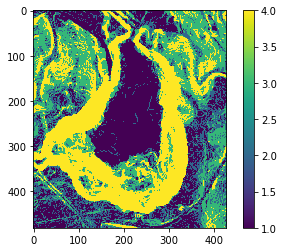

In [5]:
# zapis pliku
file2 = driver.Create('szmaragdowe_geotif_slope_reclass.tif', file.RasterXSize , file.RasterYSize , 1)
file2.GetRasterBand(1).WriteArray(slope)

# układ współrzędnych pobierany z pliku źródłowego
proj = file.GetProjection()
georef = file.GetGeoTransform()
file2.SetProjection(proj)
file2.SetGeoTransform(georef)
file2.FlushCache()

pyplot.imshow (slope, interpolation='nearest', vmin=1)
pyplot.colorbar()

# Zadanie 2

Za pomocą poznanych bibliotek python dokonaj wektoryzacji obrazu rastrowego Jeziora Szmaragdowego

1. W postaci regularnej siatki punktów w układzie współrzędnych WGS84/UTM-33N (EPSG-32633). Siatkę zapisz w bazie danych geopackage (`szmaragdowe.gpkg`).
2. W postaci izolinii oddalonych (interwał) od siebie o 1 m (`gdal_contour`) - w układzie współrzędnych EPSG:2180

In [6]:
nmt = gdal.Open("puszcza_bukowa_szmaragdowe.asc")
srs = osr.SpatialReference()
srs.ImportFromEPSG(32633)
nmt.SetProjection(srs.ExportToWkt())

band = nmt.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create("szmaragdowe_geotif_EPSG-32633", rows, cols, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(nmt.GetGeoTransform())
outdata.SetProjection(srs.ExportToWkt())
outdata.GetRasterBand(1).WriteArray(arr)
outdata.GetRasterBand(1).SetNoDataValue(-9999)
outdata.FlushCache()
nmt=None

subprocess.run("gdal_translate -of GPKG szmaragdowe_geotif_EPSG-32633.tif szmaragdowe_geotif_EPSG-32633.gpkg")

CompletedProcess(args='gdal_translate -of GPKG szmaragdowe_geotif_EPSG-32633.tif szmaragdowe_geotif_EPSG-32633.gpkg', returncode=1)

In [7]:
nmt = gdal.Open("puszcza_bukowa_szmaragdowe.asc")
srs = osr.SpatialReference()
srs.ImportFromEPSG(2180)
nmt.SetProjection(srs.ExportToWkt())

band = nmt.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create("szmaragdowe_geotif_EPSG-2180.tif", rows, cols, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(nmt.GetGeoTransform())
outdata.SetProjection(srs.ExportToWkt())
outdata.GetRasterBand(1).WriteArray(arr)
outdata.GetRasterBand(1).SetNoDataValue(-9999)
outdata.FlushCache()
nmt=None

subprocess.run("gdal_contour -i 1.0 -a elev szmaragdowe_geotif_EPSG-2180.tif szmaragdowe_geotif.shp")

CompletedProcess(args='gdal_contour -i 1.0 -a elev szmaragdowe_geotif_EPSG-2180.tif szmaragdowe_geotif.shp', returncode=1)

### Po wczytaniu w QGIS

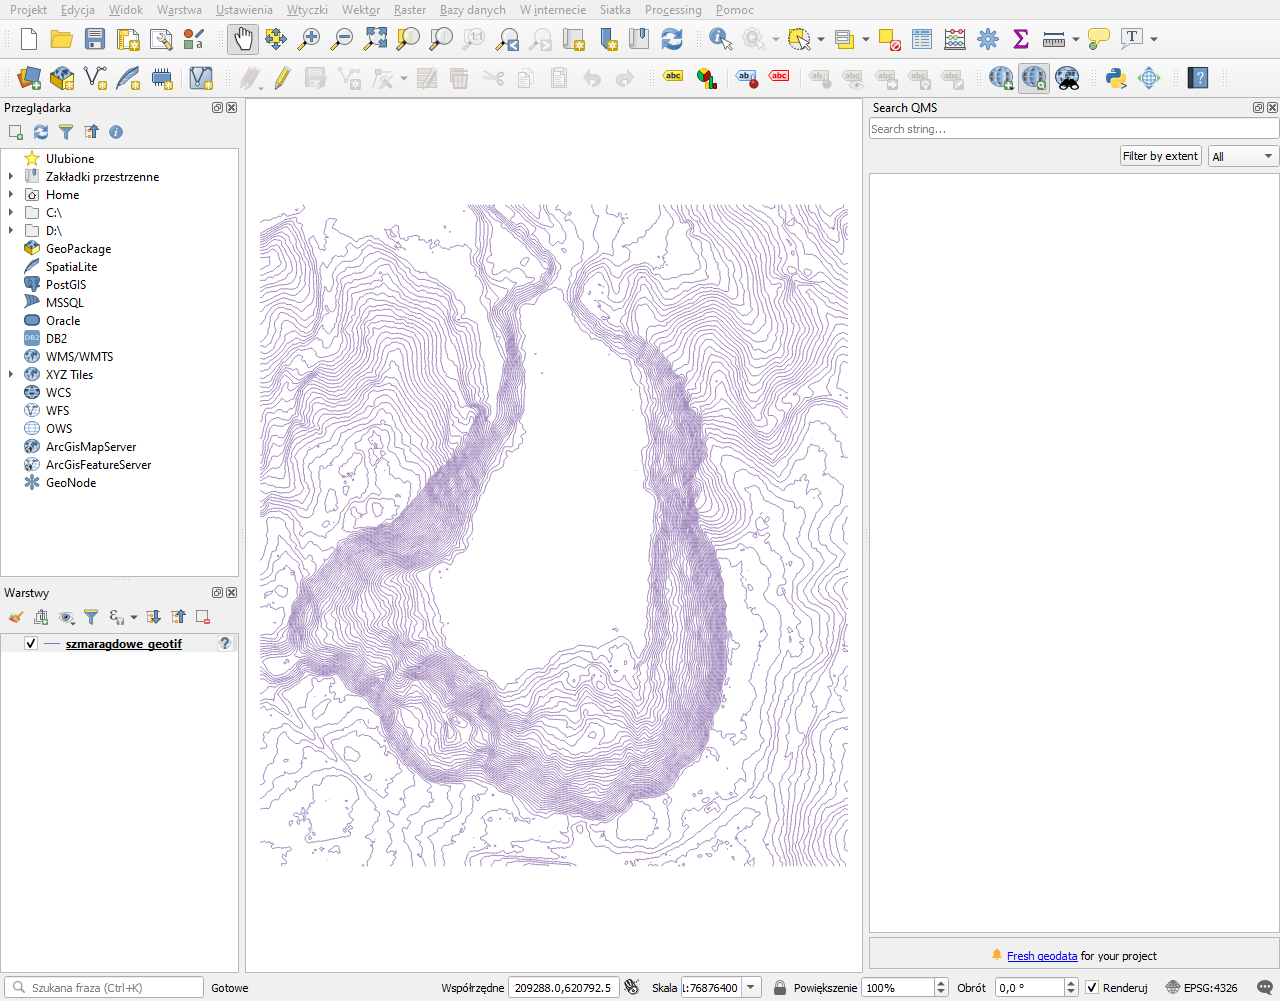

# Zadanie 3

Znajdź bibliotekę python, która umożliwia interpolację danych. Następnie dokonaj interpolacji na numerycznym modelu terenu `puszka_bukowa_szmaragdowe.asc`. Interpolacja o rozdzielczości 2.5 i 5 m/piksel.

## Rozdzielczość 2.5 metra

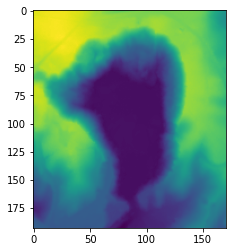

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import pykrige

grid_array, x, y, _, _ = pykrige.kriging_tools.read_asc_grid("puszcza_bukowa_szmaragdowe.asc", footer=0)

gridx = np.arange(x[0], x[-1], 2.5)
gridy = np.arange(y[0], y[-1], 2.5)

f = interpolate.interp2d(x, y, grid_array, kind='linear')
znew = f(gridx, gridy)
plt.imshow(znew)

## Rozdzielczość 5 metrów

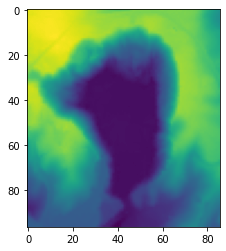

In [9]:
from pykrige.uk import UniversalKriging
import numpy as np
import matplotlib.pyplot as plt

import pykrige
grid_array, x, y, _, _ = pykrige.kriging_tools.read_asc_grid("puszcza_bukowa_szmaragdowe.asc", footer=0)

gridx = np.arange(x[0], x[-1], 5)
gridy = np.arange(y[0], y[-1], 5)

f = interpolate.interp2d(x, y, grid_array, kind='linear')
znew = f(gridx, gridy)
plt.imshow(znew)

## Próba przy użyciu PyKrige

Występują problemy z pamięcią.

In [10]:
import pykrige
grid_array, x, y, CELLSIZE, NODATA = pykrige.kriging_tools.read_asc_grid("puszcza_bukowa_szmaragdowe.asc", footer=0)

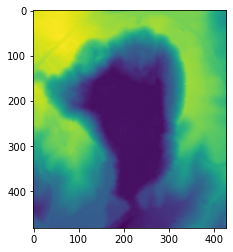

In [11]:
plt.imshow(grid_array)

In [12]:
X, Y = np.meshgrid(x, y)

In [13]:
data = np.array([X.ravel(), Y.ravel(), grid_array.ravel()]).reshape(-1, 3)

In [14]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

OK = OrdinaryKriging(
    data[:, 0],
    data[:, 1],
    data[:, 2],
    variogram_model="linear",
    verbose=False,
    enable_plotting=False,
)

MemoryError: Unable to allocate 159. GiB for an array with shape (21278916660,) and data type float64

In [ ]:
gridx = np.arange(x[0], x[-1], 2.5)
gridy = np.arange(y[0], y[-1], 2.5)

In [ ]:
z, ss = OK.execute("grid", gridx, gridy)
plt.imshow(z)
plt.show()